# init

In [1]:
import pickle
import cloudpickle
import os
import pandas as pd
import numpy as np
from functools import partial

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import calendar
from collections import defaultdict
from scipy.stats import hmean
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

# commons

In [2]:
def describe_feature(ft: pd.Series, cond):
  fig, ax = plt.subplots(1, 4, figsize=(20, 4))
  fig.suptitle(f'`{ft.name}` analysis')

  ax[0].set_title('alice')
  ax[0].plot(ft[cond], '.', alpha=0.5, color='orange')
  ax[1].set_title('other')
  ax[1].plot(ft[~cond], '.', alpha=0.5)

  ax[2].set_title('alice')
  ax[2].hist(ft[cond], edgecolor='black', color='orange')
  ax[3].set_title('other')
  ax[3].hist(ft[~cond], edgecolor='black')
  plt.show()  
  return pd.DataFrame([ft[cond].describe(), ft[~cond].describe()], index=['alice', 'other']).T

In [3]:
def search_split_value(ft: pd.Series, eta=None, iter=20, eps=1e-5, inversed=False, silent=True):
  """ Поиск оптимальной точки разделения двух распределений 
  inversed работает криво
  """
  pv = ft.median()
  if not eta:
    eta = ft.std()
  for i in range(iter):
    if inversed:
      q1 = np.mean(ft[alice] < pv)
      q2 = np.mean(ft[~alice] > pv)
    else:
      q1 = np.mean(ft[alice] > pv)
      q2 = np.mean(ft[~alice] < pv)

    if abs(q1 - q2) < eps:
      print('eps condition')
      break
    if not silent:
      print(f'{pv} | {q1} | {q2}')
    pv += eta * (q1 - q2) + eps

  print(f'optimal splitting value = {pv}')
  print(f'{round(q1 * 100, 2)}% значений Элис лежит {"ниже" if inversed else "выше"} {pv};')
  print(f'{round(q2 * 100, 2)}% значений неЭлис лежит {"выше" if inversed else "ниже"} {pv};')
  return pv

In [4]:
def plot_validation(X, y, mdl, ax, title):
  pred = mdl.predict(X)
  pred_proba = mdl.predict_proba(X)[:, 1]

  precisions, recalls, thresholds = precision_recall_curve(y, pred_proba)
  fscore = (2 * precisions * recalls) / (precisions + recalls)
  ix = fscore.argmax()

  # metrics calc
  FPR, TPR, thrsh = roc_curve(y, pred_proba)
  auc = roc_auc_score(y, pred_proba)
  f1 = f1_score(y, pred)
  acc = accuracy_score(y, pred)
  prec = precision_score(y, pred)
  recall = recall_score(y, pred)

  ax[0].set_title(f'{title}: ROC-curve')
  ax[0].set_xlabel('FPR')
  ax[0].set_ylabel('TPR')
  ax[0].plot(FPR, TPR)
  ax[0].plot((0, 1), (0, 1))
  ax[0].text(1.1, 0.9, f'auc score = {auc}', fontsize=12)
  ax[0].text(1.1, 0.8, f'f1 = {f1}', fontsize=12)
  ax[0].text(1.1, 0.7, f'accuraacy = {acc}', fontsize=12)
  ax[0].text(1.1, 0.6, f'precision = {prec}', fontsize=12)
  ax[0].text(1.1, 0.5, f'recall = {recall}', fontsize=12)
  # PR-curve
  ax[1].set_title(f'{title}: PR-curve')
  ax[1].set_xlabel('recall')
  ax[1].set_ylabel('precision')
  ax[1].plot(recalls, precisions)
  ax[1].plot((0, 1), (1, 0))
  ax[1].text(1.2, 0.9, f'threshold = {thresholds[ix]}', fontsize=12)
  ax[1].text(1.2, 0.8, f'precision = {precisions[ix]}', fontsize=12)
  ax[1].text(1.2, 0.7, f'recall = {recalls[ix]}', fontsize=12)
  ax[1].text(1.2, 0.6, f'f-score = {fscore[ix]}', fontsize=12)


# data loading

In [5]:
parent_path = 'train_data/'
train = pd.read_csv(parent_path + 'train_sessions.csv')
test = pd.read_csv(parent_path + 'test_sessions.csv')
submission = pd.read_csv(parent_path + 'sample_submission.csv')

with open(parent_path + 'site_dic.pkl', 'rb') as file:
  site_dict = pickle.load(file)
site_recover = {v: k for k, v in site_dict.items()}

target = 'target'

# preprocessing

In [6]:
# выделение признаков
site_cols = [col for col in train.columns if col.startswith('site')]
time_cols = [col for col in train.columns if col.startswith('time')]

In [7]:
class Preprocess(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    alice = y == 1
    self.site_cols = [col for col in X.columns if col.startswith('site')]
    self.time_cols = [col for col in X.columns if col.startswith('time')]
    return self

  def transform(self, X):
    sites = X[self.site_cols]
    times = X[self.time_cols].apply(pd.to_datetime)
    df = pd.DataFrame()
    df['total sites'] = sites.notna().sum(axis=1)
    # df['unique sites'] = data[site_cols].nunique(axis=1, dropna=True)       # this takes very much time!
    uqs = []
    for row in X[site_cols].replace({None: np.nan}).itertuples(index=None):   # replace nans for json compatibility in production
      _row = np.array(row)[~np.isnan(row)]      # drop nans
      uqs.append(len(set(_row)))                # get uniques count
    df['unique sites'] = uqs

    start_time = times.min(axis=1)
    end_time = times.max(axis=1)
    df['day'] = start_time.dt.day
    df['month'] = start_time.dt.month
    df['weekday'] = start_time.dt.dayofweek
    df['start hour'] = start_time.dt.hour
    df['start minute'] = start_time.dt.minute
    df['session duration'] = (end_time - start_time).dt.seconds

    df[self.site_cols] = sites
    df[self.time_cols] = times
    return df

In [8]:
%%time
# ydata = train[target]
data = train.drop(columns=target)
pre = Preprocess()
pre.fit(data, train[target])
data = pre.transform(data)
pre_test = pre.transform(test)

# разделение данных: Элис / остальные
alice = train[target] == 1

CPU times: user 4.44 s, sys: 16.8 ms, total: 4.46 s
Wall time: 4.46 s


# EDA

### overview

In [ ]:
data.head(3)

,total sites,unique sites,day,month,weekday,start hour,start minute,session duration,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,1,1,20,2,3,10,2,0,718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-20 10:02:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,10,7,22,2,5,11,19,26,890,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16
2,10,4,16,12,0,16,40,7,14769,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24


In [ ]:
data.describe()

,total sites,unique sites,day,month,weekday,start hour,start minute,session duration,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
count,253561.000000,253561.000000,253561.000000,253561.000000,253561.000000,253561.000000,253561.000000,253561.000000,253561.000000,250098.000000,246919.000000,244321.000000,241829.000000,239495.000000,237297.000000,235224.000000,233084.000000,231052.000000
mean,9.515974,5.638391,18.539582,4.511285,2.289741,12.288483,29.198146,138.494370,3243.550144,3272.400883,3303.987757,3325.109422,3343.406035,3352.312637,3395.546771,3430.157765,3438.400088,3460.388861
std,1.736208,2.496187,7.628740,3.721295,1.610467,3.159420,17.273502,295.781742,7247.006212,7307.480404,7347.809918,7371.245606,7379.758550,7380.413775,7435.727671,7473.417900,7471.062652,7492.447548
min,1.000000,1.000000,1.000000,1.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10.000000,4.000000,13.000000,2.000000,1.000000,10.000000,14.000000,7.000000,53.000000,53.000000,53.000000,52.000000,52.000000,52.000000,55.000000,55.000000,55.000000,55.000000
50%,10.000000,6.000000,19.000000,3.000000,2.000000,12.000000,29.000000,27.000000,677.000000,677.000000,677.000000,677.000000,678.000000,679.000000,679.000000,704.000000,733.000000,733.000000
75%,10.000000,8.000000,25.000000,4.000000,4.000000,15.000000,44.000000,113.000000,1980.000000,1980.000000,1986.500000,1995.000000,2054.000000,2077.000000,2197.000000,2287.000000,2366.000000,2403.000000
max,10.000000,10.000000,31.000000,12.000000,6.000000,23.000000,59.000000,1800.000000,41601.000000,41600.000000,41599.000000,41599.000000,41599.000000,41600.000000,41600.000000,41601.000000,41601.000000,41601.000000


### activity by the weekday

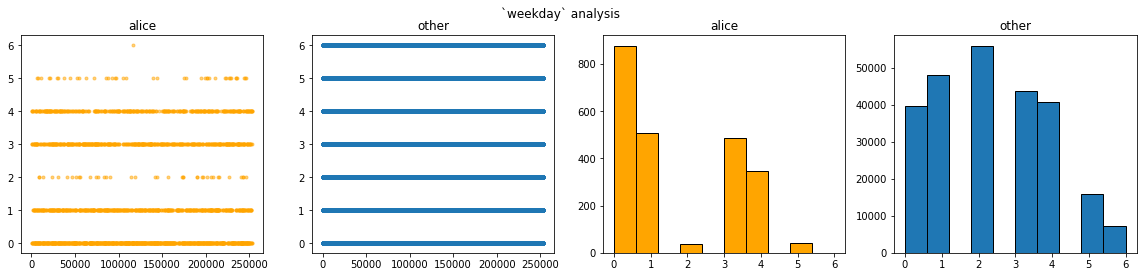

,alice,other
count,2297.000000,251264.000000
mean,1.584676,2.296186
std,1.599186,1.609149
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,3.000000,4.000000
max,6.000000,6.000000


In [ ]:
describe_feature(data['weekday'], alice)

In [ ]:
search_split_value(data['weekday'])

optimal splitting value = 1.9819157451464906
39.75% значений Элис лежит выше 1.9819157451464906;
34.94% значений неЭлис лежит ниже 1.9819157451464906;


1.9819157451464906

Активность по дням недели различается, но данные плохо разделимы по этому признаку.

### activity by day of the month

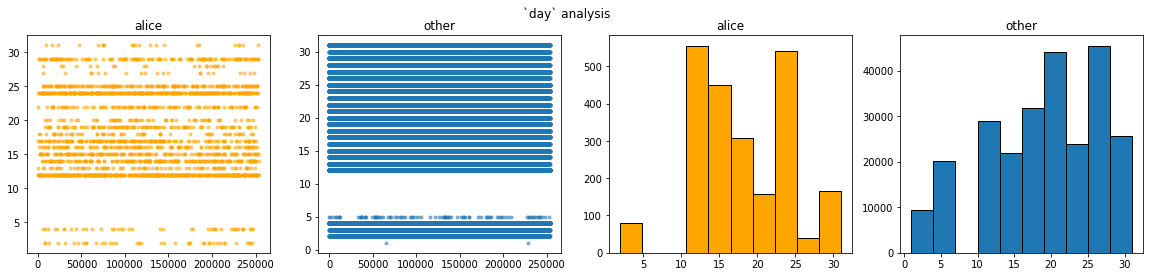

,alice,other
count,2297.000000,251264.000000
mean,18.110579,18.543504
std,6.271302,7.639936
min,2.000000,1.000000
25%,13.000000,13.000000
50%,17.000000,19.000000
75%,24.000000,25.000000
max,31.000000,31.000000


In [ ]:
describe_feature(data['day'], alice)

In [ ]:
search_split_value(data['day'])

optimal splitting value = 18.299282938963188
43.71% значений Элис лежит выше 18.299282938963188;
44.67% значений неЭлис лежит ниже 18.299282938963188;


18.299282938963188

Различий практически нет, данные неразделимы по этому признаку

### monthly activity

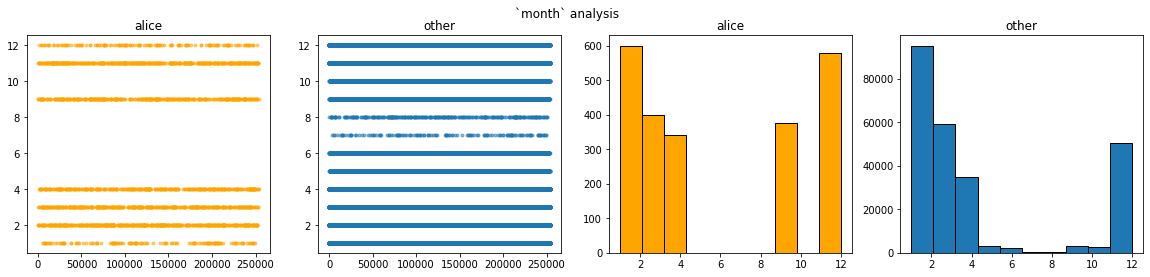

,alice,other
count,2297.000000,251264.000000
mean,5.893774,4.498647
std,3.907805,3.717184
min,1.000000,1.000000
25%,2.000000,2.000000
50%,4.000000,3.000000
75%,11.000000,4.000000
max,12.000000,12.000000


In [ ]:
describe_feature(data['month'], alice)

In [ ]:
search_split_value(data['month'])

optimal splitting value = 2.938362527972206
41.66% значений Элис лежит выше 2.938362527972206;
75.29% значений неЭлис лежит ниже 2.938362527972206;


2.938362527972206

In [ ]:
data.loc[alice, 'month'].sort_values().unique()

array([ 1,  2,  3,  4,  9, 11, 12])

В летние месцы Элис неактивна, как и обычные юзеры. Пики активности на начале зимних и всех весенних месяцах.
Единственное существенное различие - в 9ом месяце у Элис активность.
Данные неразделимы по этому признаку

### session start time

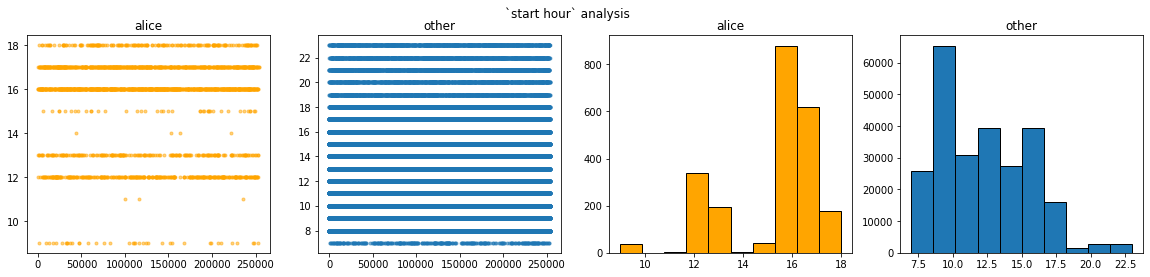

,alice,other
count,2297.000000,251264.000000
mean,15.433609,12.259731
std,2.065365,3.153245
min,9.000000,7.000000
25%,13.000000,10.000000
50%,16.000000,12.000000
75%,17.000000,14.000000
max,18.000000,23.000000


In [ ]:
describe_feature(data['start hour'], alice)

In [ ]:
search_split_value(data['start hour'])

optimal splitting value = 14.280217807360684
74.71% значений Элис лежит выше 14.280217807360684;
75.07% значений неЭлис лежит ниже 14.280217807360684;


14.280217807360684

Данные хорошо разделимы по этому признаку

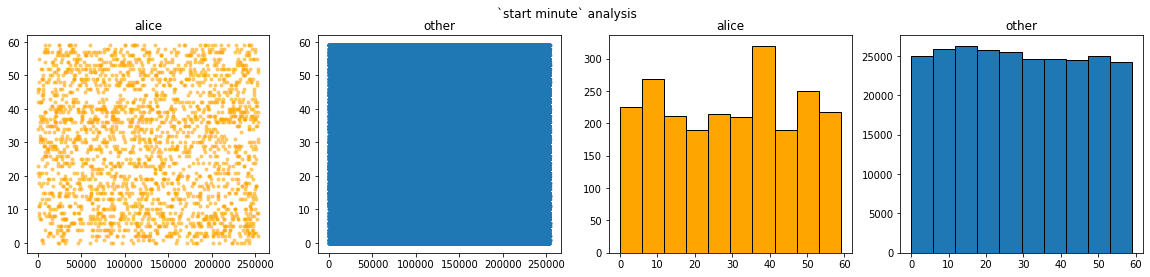

,alice,other
count,2297.000000,251264.000000
mean,29.553766,29.194895
std,17.344601,17.272851
min,0.000000,0.000000
25%,14.000000,14.000000
50%,30.000000,29.000000
75%,44.000000,44.000000
max,59.000000,59.000000


In [ ]:
describe_feature(data['start minute'], alice)

In [ ]:
search_split_value(data['start minute'])

optimal splitting value = 29.964239038102537
51.63% значений Элис лежит выше 29.964239038102537;
51.09% значений неЭлис лежит ниже 29.964239038102537;


29.964239038102537

А по этому - вообще неразделимы.

### session duration

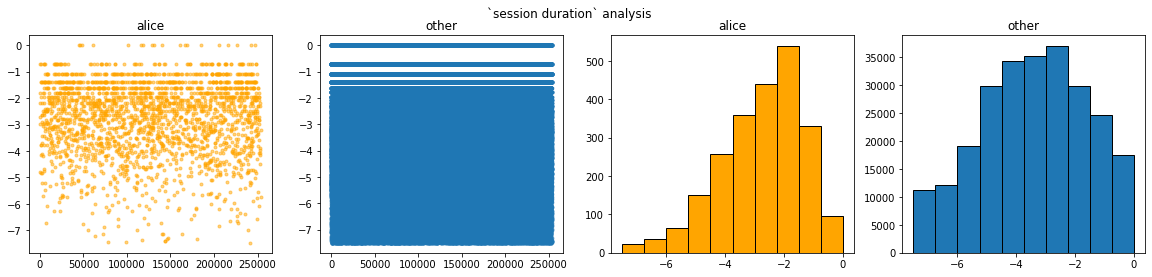

,alice,other
count,2297.000000,251264.000000
mean,-2.762770,-3.433208
std,1.374282,1.798473
min,-7.475339,-7.496097
25%,-3.663562,-4.744932
50%,-2.484907,-3.367296
75%,-1.609438,-2.079442
max,-0.000000,-0.000000


In [ ]:
session_duration = -np.log(data['session duration'] + 1)
describe_feature(session_duration, alice)

In [ ]:
search_split_value(session_duration, eta=0.05, iter=50)

optimal splitting value = -3.0445267415740336
63.04% значений Элис лежит выше -3.0445267415740336;
55.65% значений неЭлис лежит ниже -3.0445267415740336;


-3.0445267415740336

В продолжительности сессии различия есть, но данные по ним неразделимы

### unique sites per session

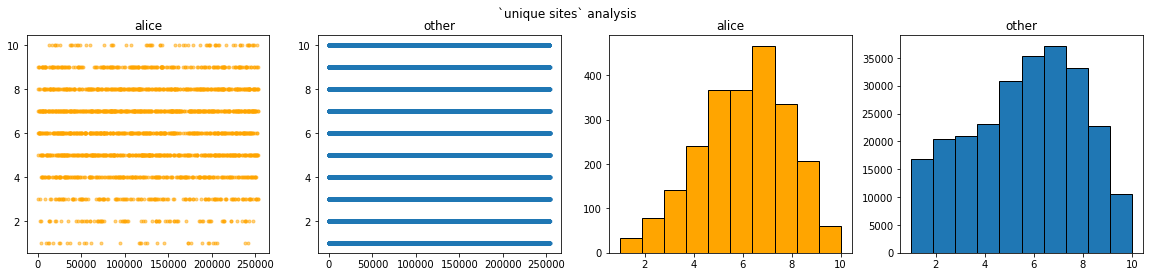

,alice,other
count,2297.000000,251264.000000
mean,6.109273,5.634086
std,2.010379,2.499787
min,1.000000,1.000000
25%,5.000000,4.000000
50%,6.000000,6.000000
75%,8.000000,8.000000
max,10.000000,10.000000


In [ ]:
describe_feature(data['unique sites'], alice)

In [ ]:
search_split_value(data['unique sites'])

optimal splitting value = 6.278358757003246
62.56% значений Элис лежит выше 6.278358757003246;
44.66% значений неЭлис лежит ниже 6.278358757003246;


6.278358757003246

По числу уникальных сайтов практически нет различий. По этому признаку данные  неразделимы

### total sites

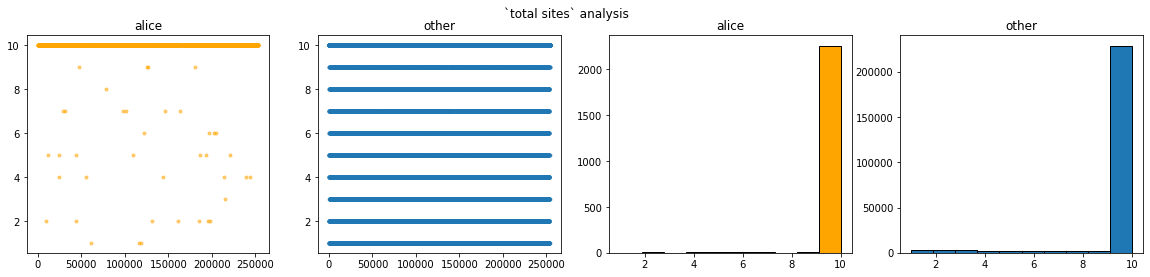

,alice,other
count,2297.000000,251264.000000
mean,9.912495,9.512350
std,0.734720,1.742295
min,1.000000,1.000000
25%,10.000000,10.000000
50%,10.000000,10.000000
75%,10.000000,10.000000
max,10.000000,10.000000


In [ ]:
describe_feature(data['total sites'], alice)

In [ ]:
search_split_value(data['total sites'])

optimal splitting value = 9.801850983215502
0.0% значений Элис лежит выше 9.801850983215502;
100.0% значений неЭлис лежит ниже 9.801850983215502;


9.801850983215502

Данные неразделимы по этому признаку

### statistics

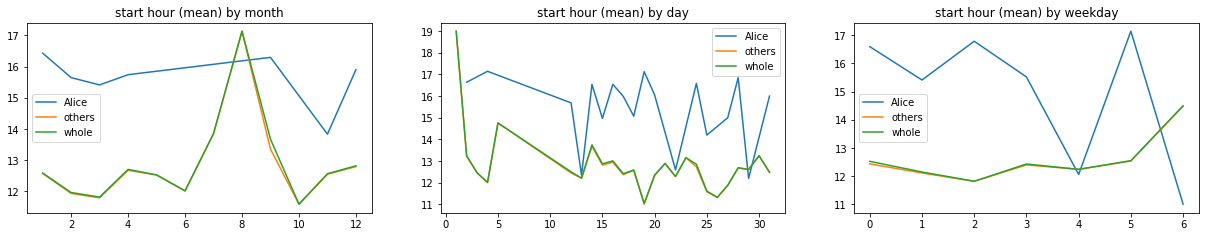

In [ ]:
# средняя start hour по дням/месяцам для Элис/неЭлис
periods = ['month', 'day', 'weekday']
fig, ax = plt.subplots(1, len(periods), figsize=(7 * len(periods), 3.5))
for i, period in enumerate(periods):
  ax[i].plot(data[alice][['start hour', period]].groupby(period).mean(), label='Alice')
  ax[i].plot(data[~alice][['start hour', period]].groupby(period).mean(), label='others')
  ax[i].plot(data[['start hour', period]].groupby(period).mean(), label='whole')
  ax[i].set_title(f'start hour (mean) by {period}')
  ax[i].legend()
plt.show()

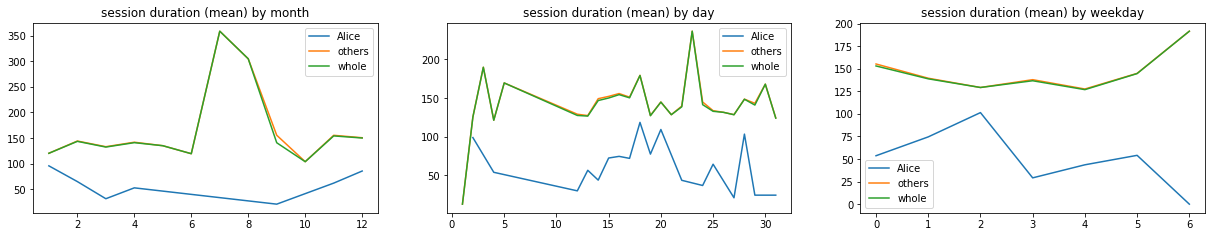

In [ ]:
# средняя продолжительность сессии по дням/месяцам для Элис/неЭлис
periods = ['month', 'day', 'weekday']
fig, ax = plt.subplots(1, len(periods), figsize=(7 * len(periods), 3.5))
for i, period in enumerate(periods):
  ax[i].plot(data[alice][['session duration', period]].groupby(period).mean(), label='Alice')
  ax[i].plot(data[~alice][['session duration', period]].groupby(period).mean(), label='others')
  ax[i].plot(data[['session duration', period]].groupby(period).mean(), label='whole')
  ax[i].set_title(f'session duration (mean) by {period}')
  ax[i].legend()
plt.show()

# featuring

### site similarity

In [9]:
class SiteSimilarity(BaseEstimator, TransformerMixin):
  """ Векторное сходство сайтов сессии на основе вероятности принадлежать таргетному классу """
  def __init__(self, suffix, method=np.linalg.norm, skipna=False, **kwargs):
    self.suffix = suffix
    self.method = method
    self.skipna = skipna
    self.kwargs = kwargs
  
  def fit(self, X, y):
    alice = y == 1
    self.site_cols = [col for col in X.columns if col.startswith('site')]
    alice_site_visits = X[alice][self.site_cols].apply(lambda col: col.value_counts()).sum(axis=1)      # сколько раз Элис открывала страницу
    total_site_visits = X[self.site_cols].apply(lambda col: col.value_counts()).sum(axis=1)             # сколько раз страница была открыта вообще
    self.alice_site_proba = (alice_site_visits / total_site_visits).fillna(0).reindex(total_site_visits.index.astype(int)).to_dict()        # вероятность, что открывающий страницу - Элис
    return self

  def transform(self, X):
    df = X.copy()
    sites_proba = X[self.site_cols].apply(lambda line: line.map(self.alice_site_proba))     # замена site id на вероятность, что сайт посещен Элис (with NaNs!)
    if self.skipna:
      df[f'site similarity ({self.suffix})'] = sites_proba.apply(lambda row: self.method(row.dropna(), **self.kwargs), axis=1)
    else:
      df[f'site similarity ({self.suffix})'] = self.method(sites_proba.fillna(0), axis=1, **self.kwargs)
    return df

In [ ]:
%%time
ss = SiteSimilarity('euklid', method=np.linalg.norm, skipna=False)
ss.fit(data, train[target])
dt = ss.transform(data)

CPU times: user 497 ms, sys: 81.3 ms, total: 579 ms
Wall time: 579 ms


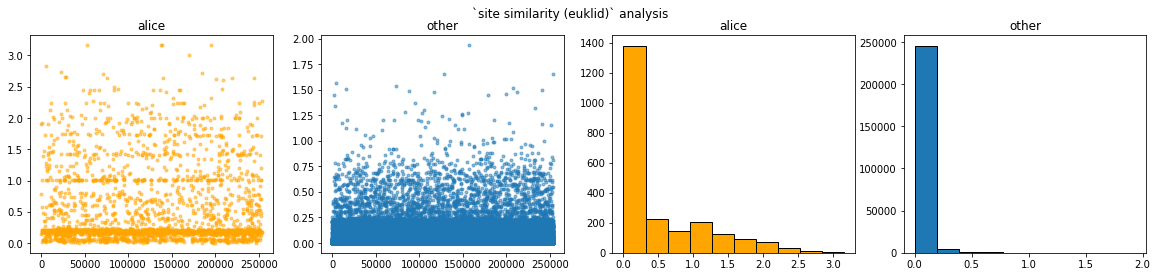

,alice,other
count,2297.000000,251264.000000
mean,0.549021,0.033876
std,0.615226,0.062374
min,0.002493,0.000000
25%,0.162075,0.005509
50%,0.209188,0.015755
75%,0.834546,0.032513
max,3.162278,1.935039


In [ ]:
describe_feature(dt['site similarity (euklid)'], alice)

In [ ]:
# search_split_value(dt['site similarity'], eta=1e-4, iter=20, inversed=False, silent=True)
search_split_value(dt['site similarity (euklid)'], eta=None, iter=25, silent=True)

eps condition
optimal splitting value = 0.07023999228203671
88.38% значений Элис лежит выше 0.07023999228203671;
88.38% значений неЭлис лежит ниже 0.07023999228203671;


0.07023999228203671

### vector norma (unused)

In [ ]:
class VectorNorma(BaseEstimator, TransformerMixin):
  def __init__(self, title, columns=[], method=np.linalg.norm, **kwargs):
    self.title = title
    self.vec_columns = columns
    self.method = method
    self.kwargs = kwargs

  def fit(self, X, y):
    return self
  
  def transform(self, X):
    df = X.copy()
    df[self.title] = self.method(X[self.vec_columns], axis=1, **self.kwargs)
    return df

In [ ]:
tvn = VectorNorma('tvn test', columns=['weekday', 'start hour'])
dt = tvn.transform(data)

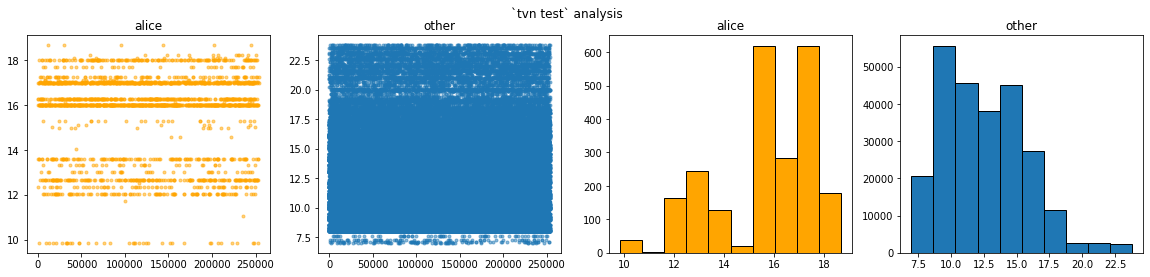

,alice,other
count,2297.000000,251264.000000
mean,15.616275,12.583860
std,1.913421,3.122857
min,9.848858,7.000000
25%,13.601471,10.049876
50%,16.031220,12.083046
75%,17.000000,15.000000
max,18.681542,23.769729


In [ ]:
describe_feature(dt['tvn test'], alice)

In [ ]:
search_split_value(dt['tvn test'])

optimal splitting value = 14.85504414431832
74.71% значений Элис лежит выше 14.85504414431832;
74.14% значений неЭлис лежит ниже 14.85504414431832;


14.85504414431832

### Z-Feature

In [10]:
class ZFeature(BaseEstimator, TransformerMixin):
  """ Измерение условного Z-расстояния между значением и средней по признаку """
  def __init__(self, on=[], as_delta=False):
    self.on = on
    self.as_delta = as_delta
  
  def fit(self, X, y):
    alice = y == 1
    self.on = [col for col in self.on if col in X.columns]
    self.alice_stats = X.loc[alice, self.on].describe().T    # статистики по Элис
    self.other_stats = X.loc[~alice, self.on].describe().T   # статистики по неЭлис
    return self

  def transform(self, X):
    df = X.copy()
    if self.as_delta:
      # one feat
      col_names = [f'Z-prox {feat}' for feat in self.on]
      # alice_sigma_distance = abs((df[self.on] - self.other_stats['mean']) * np.sqrt(self.other_stats['count']) / self.other_stats['std'])
      # other_sigma_distance = abs((df[self.on] - self.alice_stats['mean']) * np.sqrt(self.alice_stats['count']) / self.alice_stats['std'])
      alice_sigma_distance = abs((df[self.on] - self.other_stats['mean']) / self.other_stats['std'])
      other_sigma_distance = abs((df[self.on] - self.alice_stats['mean']) / self.alice_stats['std'])
      df[col_names] = abs(alice_sigma_distance - other_sigma_distance)
    else:
      # two feats
      col_names = [f'Z-prox {feat}: alice' for feat in self.on]
      # df[col_names] = (df[self.on] - self.alice_stats['mean']) * np.sqrt(self.other_stats['count']) / self.alice_stats['std']
      df[col_names] = (df[self.on] - self.alice_stats['mean']) / self.alice_stats['std']
      col_names = [f'Z-prox {feat}: others' for feat in self.on]
      # df[col_names] = (df[self.on] - self.other_stats['mean']) * np.sqrt(self.alice_stats['count']) / self.other_stats['std']
      df[col_names] = (df[self.on] - self.other_stats['mean']) / self.other_stats['std']
    
    return df

In [ ]:
%%time
zf = ZFeature(on=['start hour'], as_delta=True)
zf.fit(data, train[target])
zdt = zf.transform(dt)

CPU times: user 83.9 ms, sys: 13.9 ms, total: 97.8 ms
Wall time: 98.8 ms


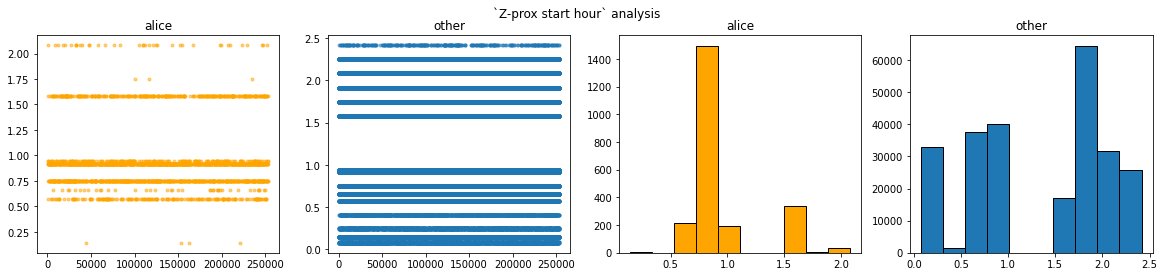

,alice,other
count,2297.000000,251264.000000
mean,0.957245,1.342704
std,0.325640,0.713017
min,0.142221,0.076721
25%,0.744890,0.744890
50%,0.911932,1.580101
75%,0.943530,1.914186
max,2.081228,2.415312


In [ ]:
describe_feature(zdt['Z-prox start hour'], alice)

In [ ]:
search_split_value(zdt['Z-prox start hour'], eta=0.05)

optimal splitting value = 1.2918284703838463
16.59% значений Элис лежит выше 1.2918284703838463;
44.69% значений неЭлис лежит ниже 1.2918284703838463;


1.2918284703838463

### apply weights

In [11]:
class ApplyWeights(BaseEstimator, TransformerMixin):
  def __init__(self, on=[], weightby=[], log=False):
    self.on = on
    self.weightby = weightby
    self.log = log

  def fit(self, X, y):
    alice = y == 1
    for feat in self.weightby:
      if feat not in X.columns:
        continue
      # calc weights
      w = (X[alice][feat].value_counts() / X[alice][feat].size).to_dict()
      setattr(self, f'{feat}_weights', w)

    return self
  
  def transform(self, X):
    df = X.copy()
    self.on = [col for col in self.on if col in df.columns]

    for feat in self.weightby:
      if feat not in df.columns:
        continue
      # apply weights
      w = getattr(self, f'{feat}_weights', {})
      df[self.on] = df[self.on].mul(df[feat].map(w).fillna(1), axis=0).values

    if self.log:
      df[self.on] = df[self.on].applymap(lambda x: -np.log(x) if x != 0 else 0)
      df.loc[:, self.on].fillna(0, inplace=True)

    return df

In [ ]:
%%time
# aw = ApplyWeights(on=['unique sites', 'session duration'], weightby=['start hour'], log=False)
# aw = ApplyWeights(on=['unique sites', 'session duration'], weightby=['weekday'], log=False)
aw = ApplyWeights(on=['unique sites', 'session duration'], weightby=['start hour', 'weekday'], log=False)
aw.fit(data, train[target])
awd = aw.transform(data)

CPU times: user 59.2 ms, sys: 37.8 ms, total: 97 ms
Wall time: 98.1 ms


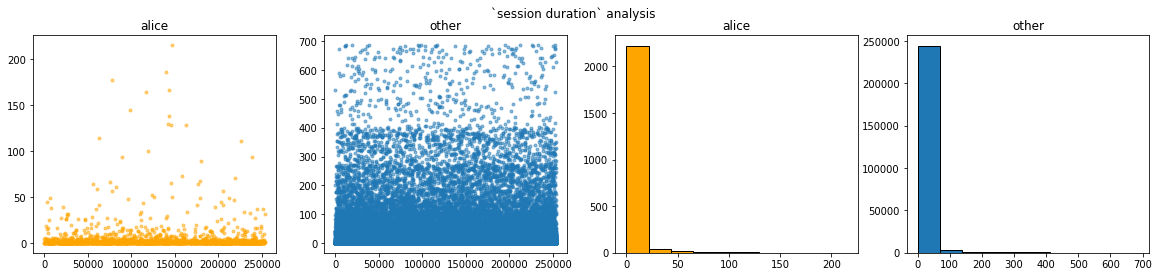

,alice,other
count,2297.000000,251264.000000
mean,3.727107,8.361460
std,13.565661,37.842289
min,0.000000,0.000000
25%,0.237753,0.010755
50%,0.684505,0.150631
75%,2.071237,1.785054
max,215.259839,686.460601


In [ ]:
describe_feature(awd['session duration'], alice)

In [ ]:
search_split_value(awd['session duration'], eta=0.025, iter=200)

optimal splitting value = 0.4283671287108371
61.43% значений Элис лежит выше 0.4283671287108371;
61.16% значений неЭлис лежит ниже 0.4283671287108371;


0.4283671287108371

### threshold encoder

In [12]:
# разделение по threshold: 1: x > threshold; 0: x <= threshold
class ThresholdEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, thresholds={}):
    self.thresholds = thresholds

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    df = X.copy()
    self.thresholds = {k: v for k, v in self.thresholds.items() if k in X.columns}
    new_features = [f'threshold {col}' for col in self.thresholds.keys()]
    df[new_features] = (df[self.thresholds.keys()] > pd.Series(self.thresholds)).astype(np.int8)

    return df

In [ ]:
%%time
te = ThresholdEncoder(data[site_cols].mean(axis=0).to_dict())
# te.fit(data)
te.transform(data)


CPU times: user 54.6 ms, sys: 15.3 ms, total: 69.9 ms
Wall time: 64.5 ms


### LDA model

In [13]:
class LDAEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, num_topics, **kwargs):
    self.num_topics = num_topics
    self.kwargs = kwargs

  def __prepare(self, X):
    urls = X.applymap(lambda x: site_recover.get(x, None))
    urls = urls.apply(lambda row: ' '.join(row.dropna().values), axis=1).str.replace('.', ' ', regex=False)
    urls = urls.str.split()
    return urls

  def fit(self, X, y=None):
    self.site_cols = [col for col in X.columns if col.startswith('site')]
    urls = self.__prepare(X[self.site_cols])
    self.dictionary = Dictionary(urls.tolist())
    corpus = urls.apply(self.dictionary.doc2bow).tolist()
    self.lda = LdaModel(corpus, id2word=self.dictionary, num_topics=self.num_topics, random_state=23, **self.kwargs)
    return self

  def transform(self, X):
    df = X.copy()
    urls = self.__prepare(df[self.site_cols])
    docs = urls.apply(self.dictionary.doc2bow)
    lda_tuples = [self.lda[doc] for doc in docs]
    topics = [dict(lt) for lt in lda_tuples]
    vectors = np.array([[topic.get(i, 0) for i in range(self.num_topics)] for topic in topics])
    
    feature_names = [f'topic_{i}' for i in range(self.num_topics)]
    features = pd.DataFrame(vectors, columns=feature_names, index=df.index)
    return pd.concat([df, features], axis=1)

In [ ]:
# %%time
# ldae = LDAEncoder(7,)
# ldae.fit(data)
# dt = ldae.transform(data)

# topics = [col for col in dt.columns if col.startswith('topic')]
# tp = dt[alice][topics]

In [ ]:
# tp.describe()

In [ ]:
# describe_feature(dt['topic_1'], alice)

In [ ]:
# search_split_value(dt['topic_1'], )

In [ ]:
# # show topics
# topics = ldae.lda.show_topics(num_topics=20, num_words=10, formatted=False)
# topic_words = [(topic_num, [word for word, _ in words_proba_bundle]) for topic_num, words_proba_bundle in topics]
# for topic, words in topic_words:
#   print(f'{topic}: ', *words)

In [ ]:
# Элис - ютубер! лолкек

### dummies & drop & scale

In [14]:
class SetDummies(BaseEstimator, TransformerMixin):
  def __init__(self, *, on, drop_source=True):
    self.on = on
    self.drop_source = drop_source
    
  def fit(self, X, y=None):
    self.on = [col for col in self.on if col in X.columns]
    self.dum_cols = pd.get_dummies(X[self.on].astype('category')).columns
    self.columns_order = X.columns
    return self

  def transform(self, X):
    df = X.copy()
    df[self.on] = df[self.on].astype('category')
    dumm = pd.get_dummies(df[self.on])
    not_exists = [col for col in self.dum_cols if col not in dumm.columns]
    dumm[not_exists] = 0
    df = pd.concat([df, dumm], axis=1)
    df = df[self.columns_order]
    if self.drop_source:
      df.drop(columns=self.on, inplace=True)
    return df

In [15]:
class DropColumns(BaseEstimator, TransformerMixin):
  def __init__(self, drop=[], leave=[]):
    self.drop = drop
    self.leave = leave

  def fit(self, X, y=None):
    self.leave = list(set(self.leave) & set(X.columns))
    self.drop = list(set(self.drop) & set(X.columns))
    return self

  def transform(self, X):
    if self.leave:
      return X[self.leave]
    elif self.drop:
      return X.drop(columns=self.drop)
    else:
      return X

In [16]:
class DataScaler(BaseEstimator, TransformerMixin):
  def __init__(self, scaler, scale=[], keep=[], keepsuffix=[]):
    self.scaler = scaler()
    self.scale = scale
    self.keep = keep
    self.keepsuffix = keepsuffix
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    df = X.copy()
    if self.keep:
      columns = [col for col in df.columns if col not in self.keep]
    elif not self.scale:
      columns = df.columns
    else:      
      columns = [col for col in self.scale if col in df.columns]
    
    columns = [col for col in columns if not any([col.startswith(suff) for suff in self.keepsuffix])]

    self.scaler.fit(df[columns])
    df[columns] = self.scaler.transform(df[columns])
    return df

# prepare data

In [17]:
# T4 + LDA7 + dummies
prepare_pipeline = Pipeline([('preprocess', Preprocess()),
                             ('weights 1', ApplyWeights(on=['unique sites', 'session duration'], weightby=['start hour', 'weekday'], log=False)),
                             ('z-prox 1', ZFeature(on=['start hour', 'unique sites',], as_delta=True)),

                             ('site similarity (euklid)', SiteSimilarity(suffix='euklid', method=np.linalg.norm, ord=2)),
                             ('z-prox 2', ZFeature(on=['site similarity (euklid)'], as_delta=True)),

                             ('thresholds', ThresholdEncoder({'session duration': 0.428367})),

                             ('LDA', LDAEncoder(7)),

                             ('dummies', SetDummies(on=['month', 'weekday', 'start hour'], drop_source=True)),

                             ('drop', DropColumns(drop=[*site_cols, *time_cols, 'day', 'start minute', 'total sites', 'unique sites',
                                                        'Z-prox site similarity (harmonic): alice', 'site similarity (harmonic)'])),
                            #  ('scale', DataScaler(StandardScaler, keepsuffix=['Z-prox', 'threshold', 'topic', 'month', 'weekday', 'start hour'])),
                             ])

In [18]:
%%time
X_whole, y_whole = train.drop(columns=target), train[target]
prepare_pipeline.fit(X_whole, y_whole)
X_whole = prepare_pipeline.transform(X_whole)

X_train, X_valid, y_train, y_valid = train_test_split(X_whole, y_whole, test_size=0.3, random_state=27, shuffle=False)
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

# modeling

## SGD

In [ ]:
# SGD - 
model = SGDClassifier(# max_iter=5000,
                      loss='log',   # log / modified_huber
                      learning_rate='adaptive',
                      # learning_rate='invscaling',
                      eta0=0.45,
                      penalty='l1',
                      alpha=1e-6,
                      # power_t=0.2,
                      # class_weight='balanced',
                      # class_weight={0: 1, 1: disbalance/15},
                      n_jobs=-1,
                      # early_stopping=True,
                      random_state=17)
model.fit(X_train, y_train)

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid);

In [ ]:
# vizualize
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
fig.subplots_adjust(wspace=1.1, hspace=0.35)
plot_validation(X_train, y_train, model, ax[0], 'Train')
plot_validation(X_valid, y_valid, model, ax[1], 'Valid')
plot_validation(X_whole, y_whole, model, ax[2], 'Whole')
plt.show()

In [ ]:
# features importances
# pd.DataFrame(model.coef_, columns=X_train.columns).T.sort_values(0)

## CatBoost

In [ ]:
model = CatBoostClassifier(verbose=100,
                          #  iterations=500,
                          #  learning_rate=0.05,
                           allow_writing_files=False,
                           use_best_model=True,
                           eval_metric='F1',
                           class_weights=[1, disbalance],
                           cat_features=['month', 'weekday', 'start hour', 'threshold session duration'],
                           random_state=14)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid);

In [ ]:
# vizualize
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
fig.subplots_adjust(wspace=1.1, hspace=0.35)
plot_validation(X_train, y_train, model, ax[0], 'Train')
plot_validation(X_valid, y_valid, model, ax[1], 'Valid')
plot_validation(X_whole, y_whole, model, ax[2], 'Whole')
plt.show()

## LGBM

In [46]:
model = LGBMClassifier(max_depth=3,
                       n_estimators=150,
                       learning_rate=0.05,
                       n_jobs=-1,
                       class_weight='balanced',
                       random_state=37)
model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=3,
               n_estimators=150, random_state=37)

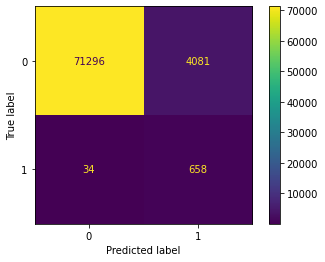

In [47]:
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid);

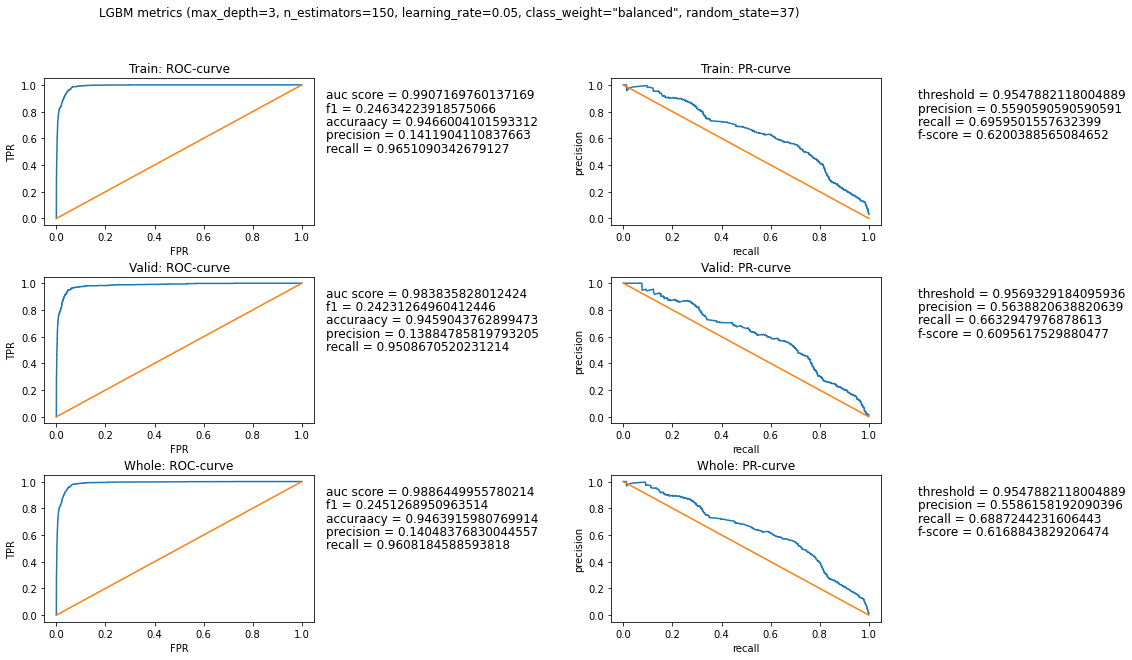

In [48]:
# vizualize
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
fig.subplots_adjust(wspace=1.1, hspace=0.35)
fig.suptitle('LGBM metrics (max_depth=3, n_estimators=150, learning_rate=0.05, class_weight="balanced", random_state=37)')
plot_validation(X_train, y_train, model, ax[0], 'Train')
plot_validation(X_valid, y_valid, model, ax[1], 'Valid')
plot_validation(X_whole, y_whole, model, ax[2], 'Whole')
plt.show()

## RF

In [ ]:
model = RandomForestClassifier(max_depth=8,
                               min_samples_leaf=30,
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=31)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=30, n_jobs=-1, random_state=31)

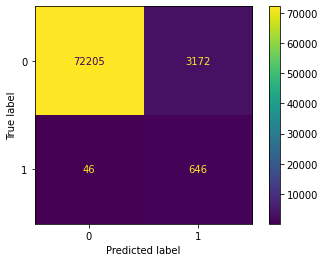

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid);

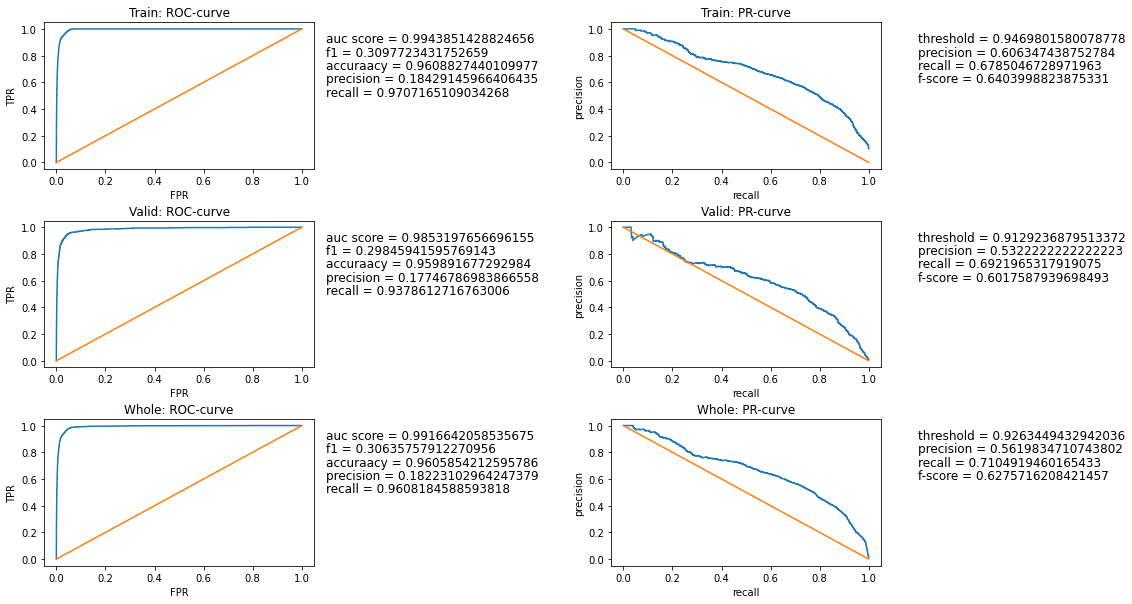

In [ ]:
# vizualize
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
fig.subplots_adjust(wspace=1.1, hspace=0.35)
plot_validation(X_train, y_train, model, ax[0], 'Train')
plot_validation(X_valid, y_valid, model, ax[1], 'Valid')
plot_validation(X_whole, y_whole, model, ax[2], 'Whole')
plt.show()

## predictions

In [49]:
%%time
X_test = prepare_pipeline.transform(test)

CPU times: user 25 s, sys: 93 µs, total: 25 s
Wall time: 25 s


In [50]:
submission[target] = model.predict_proba(X_test)[:, 1]
submission.to_csv('alice-sub.csv', index=False)
submission.isna().any()

session_id    False
target        False
dtype: bool

In [53]:
submission

,session_id,target
0,1,0.005708
1,2,0.001635
2,3,0.003824
3,4,0.007108
4,5,0.005382
...,...,...
82792,82793,0.007855
82793,82794,0.012100
82794,82795,0.008594
82795,82796,0.007185


# final pipeline (not the same as prepare_pipeline + model !)

Это не объединение, а другой вариант: `prepare_pipeline` собирает статистики (`fit`) со всей обучающей выборки, а не с ее части, как в `final_pipeline`.

In [ ]:
%%time
fit_params = {'max_depth': 8,
              'min_samples_leaf': 25,
              'class_weight': 'balanced',
              'n_jobs': -1,
              'random_state': 31,
              }


Xt, Xv, yt, yv = train_test_split(train.drop(columns=target), train[target], test_size=0.3, random_state=27, shuffle=False)

final_pipeline = Pipeline([('prepare', prepare_pipeline),
                           ('fit', RandomForestClassifier(**fit_params))])

final_pipeline.fit(Xt, yt)

CPU times: user 3min 31s, sys: 6.86 s, total: 3min 38s
Wall time: 3min 22s


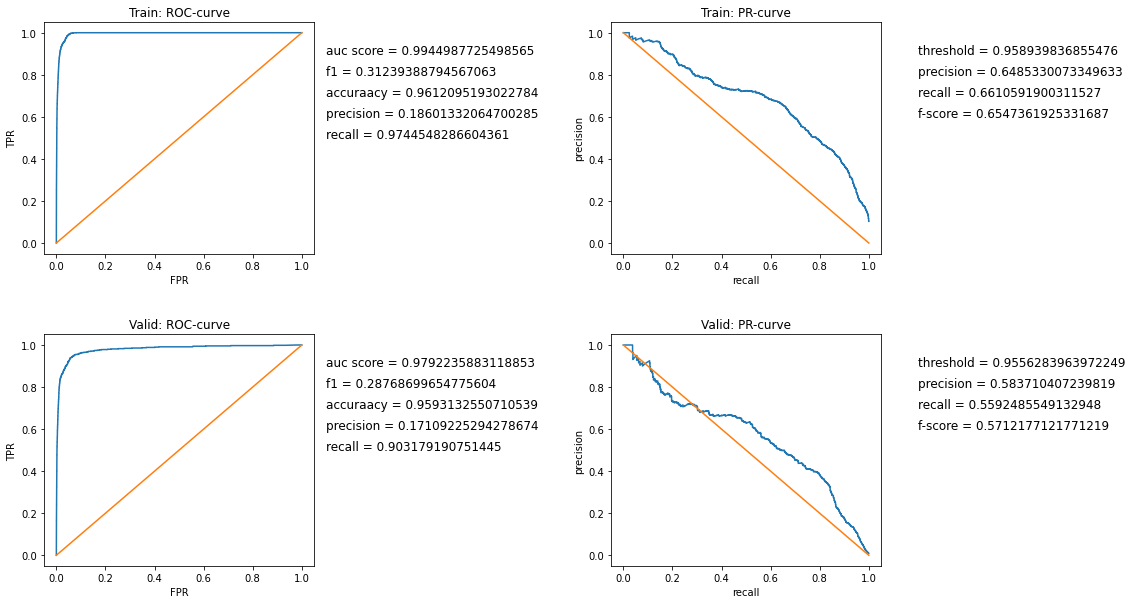

In [ ]:
# vizualize
fig, ax = plt.subplots(2, 2, figsize=(15, 6.5))
fig.subplots_adjust(wspace=1.1, hspace=0.35)
plot_validation(Xt, yt, final_pipeline, ax[0], 'Train')
plot_validation(Xv, yv, final_pipeline, ax[1], 'Valid')
plt.show()

In [ ]:
submission[target] = final_pipeline.predict_proba(test)[:, 1]
submission.to_csv('alice-sub-final.csv', index=False)
submission.isna().any()

session_id    False
target        False
dtype: bool

In [ ]:
submission

,session_id,target
0,1,0.002154
1,2,0.000285
2,3,0.007332
3,4,0.003650
4,5,0.005723
...,...,...
82792,82793,0.014982
82793,82794,0.003687
82794,82795,0.003853
82795,82796,0.005245


# save

In [52]:
# # pickle
# with open('prepare_pipeline.pkl', 'wb') as pf:
#   pickle.dump(prepare_pipeline, pf)
# with open('model.pkl', 'wb') as pf:
#   pickle.dump(model, pf)

# cloudpickle
with open('prepare_pipeline.cpkl', 'wb') as pf:
  cloudpickle.dump(prepare_pipeline, pf)
with open('model.cpkl', 'wb') as pf:
  cloudpickle.dump(model, pf)

# # dill
# with open('prepare_pipeline.dill', 'wb') as pf:
#   dill.dump(prepare_pipeline, pf)
# with open('model.dill', 'wb') as pf:
#   dill.dump(model, pf)

# with open('final_pipeline.pkl', 'wb') as pf:
#   pickle.dump(final_pipeline, pf)

In [ ]:
# load
with open('prepare_pipeline.cpkl', 'rb') as pf:
  ppl = pickle.load(pf)
with open('model.cpkl', 'rb') as pf:
  mdl = pickle.load(pf)